<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# Time Series Prediction using RNNs from scratch

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Generate the Dataset

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [3]:
np.random.seed(42)

n_steps = 50
n_sequences = 10000
n_train_sequences = 7000
n_valid_sequences = 2000
n_test_sequences = 1000

series = generate_time_series(n_sequences, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [4]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

Saving figure time_series_plot


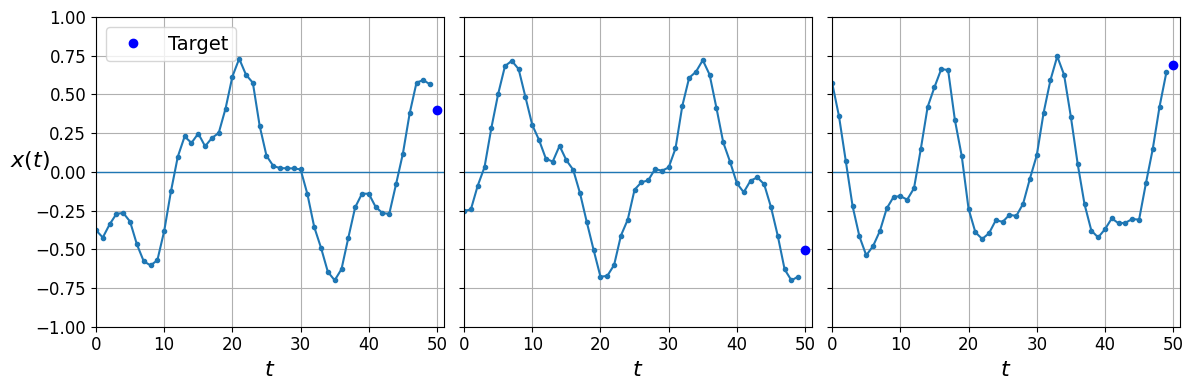

In [5]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
save_fig("time_series_plot")
plt.show()

**Note**: in this notebook, the blue dots represent targets, and red crosses represent predictions. In the book, I first used blue crosses for targets and red dots for predictions, then I reversed this later in the chapter. Sorry if this caused some confusion.

In [6]:
def simple_rnn_forward(x, initial_state, Wx, Wy, b):
    
    # x: (batch_size, n_steps, n_inputs)
    # initial_state: (batch_size, n_neurons)
    # Wx: (n_inputs, n_neurons)
    # Wy: (n_neurons, n_neurons)
    #b: (n_neurons)
    
    n_steps = x.shape[1]
    h = initial_state
    for step in range(n_steps):
        h = np.tanh(x[:, step, :] @ Wx + h @ Wy + b)
    return h

In [13]:
n_neurons = 20
batch_size = 5

x = X_train[:batch_size,:,:]

print(x.shape)

h = simple_rnn_forward(x, initial_state=np.zeros(n_neurons), Wx=np.random.randn(1,n_neurons), Wy=np.random.randn(n_neurons,n_neurons), b=np.zeros(n_neurons))
print(h)


(5, 50, 1)
[[ 0.99999999  0.99999948 -0.93322169  1.          0.93866007 -0.40705476
  -0.99999931  0.99999975  0.902595    0.99932302 -0.99996987 -0.98355689
  -0.99996291 -0.9999612  -0.99795042  0.51862641  0.99882917 -0.99164151
  -0.9999207   0.14043821]
 [ 0.89521471  1.         -0.97765997  0.42889893 -0.99997281 -0.47830198
   0.98765288  0.99366474  0.51312285 -0.99988488 -0.9998209  -0.97499152
   0.99926601 -0.99484134 -0.98971124  0.99999926 -0.84919967 -0.19351351
  -0.94912719 -0.99999999]
 [-0.45595294 -0.99999509  0.99541662  0.99789372  0.99882609  0.98770438
  -0.99963783  0.988182    0.31204365  0.99559052  0.83532663  0.99999962
  -0.88937397 -0.93744648  0.39903433 -0.99962428  0.99990469 -0.99998296
  -0.99746358  0.52812429]
 [ 0.99980151  0.57185321 -0.70813566  0.94755577  0.99890492 -0.99998573
  -0.96378784 -0.48596678  0.99613035 -0.99996939 -0.97294045 -0.99875842
  -0.99396284 -0.99841629 -0.99916617  0.99999839  0.9998905  -0.99636545
   0.99998531  0.999

## Deep RNNs

In [17]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

optimizer=tf.keras.optimizers.legacy.Adam()
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
  5/219 [..............................] - ETA: 7s - loss: 0.2693 

2023-04-04 13:04:50.263686: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


219/219 [==============================] - 9s 37ms/step - loss: 0.0254 - val_loss: 0.0053
Epoch 2/20
219/219 [==============================] - 8s 34ms/step - loss: 0.0045 - val_loss: 0.0036
Epoch 3/20
219/219 [==============================] - 8s 37ms/step - loss: 0.0034 - val_loss: 0.0030
Epoch 4/20
219/219 [==============================] - 8s 35ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 5/20
219/219 [==============================] - 8s 36ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 6/20
219/219 [==============================] - 8s 36ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 7/20
219/219 [==============================] - 8s 34ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 8/20
219/219 [==============================] - 8s 35ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 9/20
219/219 [==============================] - 8s 36ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 10/20
219/219 [==============================] - 8s 36ms/step - loss: 0.0028 - val_loss: 0.0027


In [18]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 13ms/step - loss: 0.0025


0.0025295214727520943

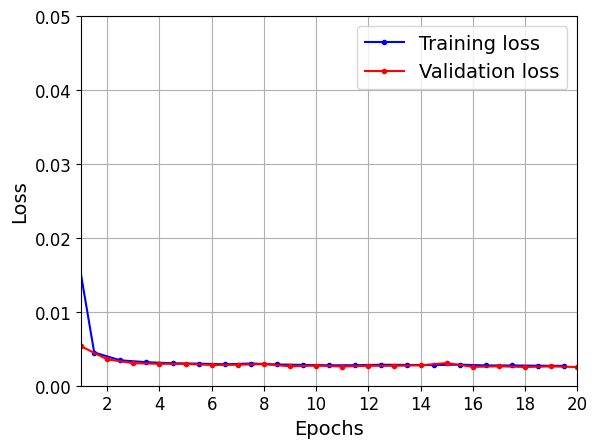

In [19]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 [==============================] - 1s 11ms/step


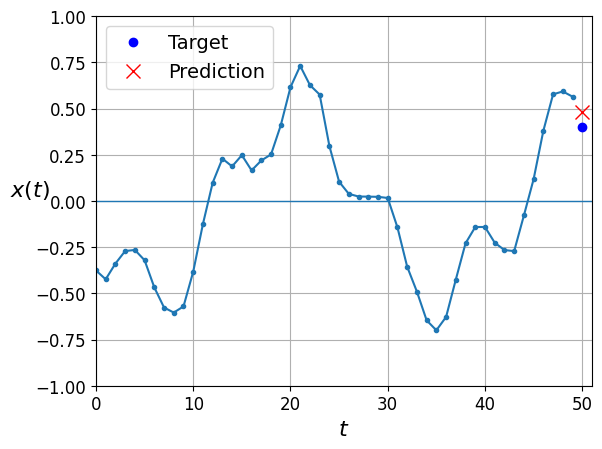

In [20]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Make the second `SimpleRNN` layer return only the last output:

In [21]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

optimizer=tf.keras.optimizers.legacy.Adam()
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 6s 25ms/step - loss: 0.0225 - val_loss: 0.0055
Epoch 2/20
219/219 [==============================] - 5s 25ms/step - loss: 0.0045 - val_loss: 0.0039
Epoch 3/20
219/219 [==============================] - 5s 25ms/step - loss: 0.0034 - val_loss: 0.0030
Epoch 4/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 5/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 6/20
219/219 [==============================] - 5s 25ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 7/20
219/219 [==============================] - 5s 25ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 8/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 9/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 10/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0028 - val_lo

In [22]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 11ms/step - loss: 0.0026


0.0025954328011721373

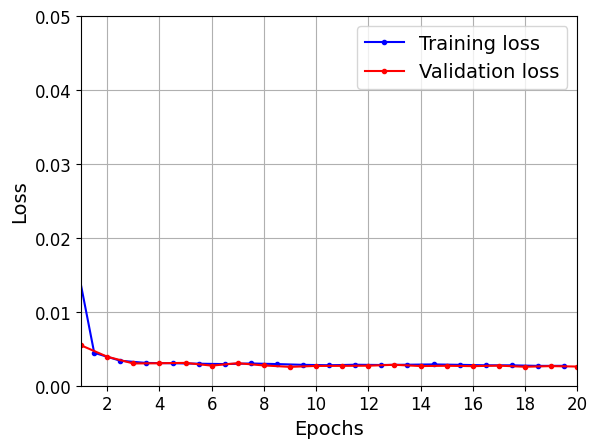

In [23]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 [==============================] - 1s 10ms/step


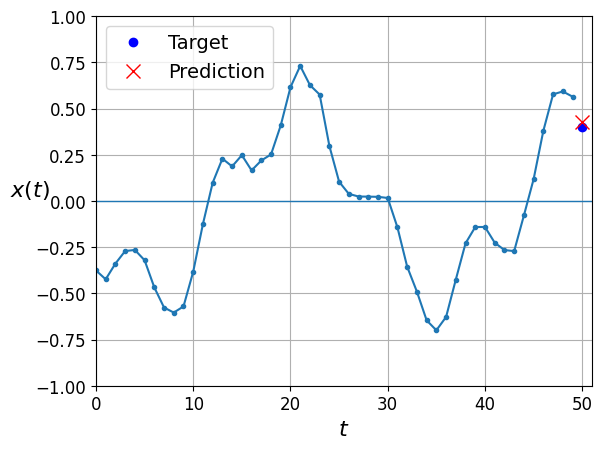

In [24]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Forecasting Several Steps Ahead

In [25]:
np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

1/1 [==============================] - 0s 20ms/step


In [26]:
Y_pred.shape

(1, 10, 1)

Saving figure forecast_ahead_plot


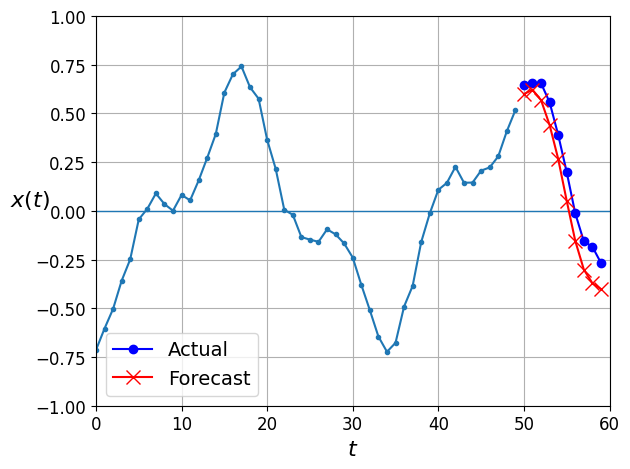

In [27]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()

Now let's use this model to predict the next 10 values. We first need to regenerate the sequences with 9 more time steps.

In [28]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

Now let's predict the next 10 values one by one:

In [29]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

63/63 [==============================] - 0s 5ms/step


In [30]:
Y_pred.shape

(2000, 10)

In [31]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.021216832

Let's compare this performance with some baselines: naive predictions and a simple linear model:

In [32]:
Y_naive_pred = np.tile(X_valid[:, -1], 10) # take the last time step value, and repeat it 10 times
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.25697407

In [33]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

optimizer=tf.keras.optimizers.legacy.Adam()
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 0s 1ms/step - loss: 0.1342 - val_loss: 0.0637
Epoch 2/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0512 - val_loss: 0.0437
Epoch 3/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0390 - val_loss: 0.0360
Epoch 4/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0336 - val_loss: 0.0320
Epoch 5/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0305 - val_loss: 0.0294
Epoch 6/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0282 - val_loss: 0.0276
Epoch 7/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0265 - val_loss: 0.0260
Epoch 8/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0253 - val_loss: 0.0247
Epoch 9/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0242 - val_loss: 0.0238
Epoch 10/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0233 - val_loss: 0.0229

Now let's create an RNN that predicts all 10 next values at once:

In [34]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

optimizer=tf.keras.optimizers.legacy.Adam()
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 6s 24ms/step - loss: 0.0568 - val_loss: 0.0303
Epoch 2/20
219/219 [==============================] - 5s 25ms/step - loss: 0.0276 - val_loss: 0.0233
Epoch 3/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0191 - val_loss: 0.0157
Epoch 4/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0157 - val_loss: 0.0147
Epoch 5/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0133 - val_loss: 0.0114
Epoch 6/20
219/219 [==============================] - 5s 25ms/step - loss: 0.0122 - val_loss: 0.0106
Epoch 7/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0113 - val_loss: 0.0102
Epoch 8/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0111 - val_loss: 0.0095
Epoch 9/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0108 - val_loss: 0.0114
Epoch 10/20
219/219 [==============================] - 5s 25ms/step - loss: 0.0103 - val_lo

In [35]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

1/1 [==============================] - 0s 127ms/step


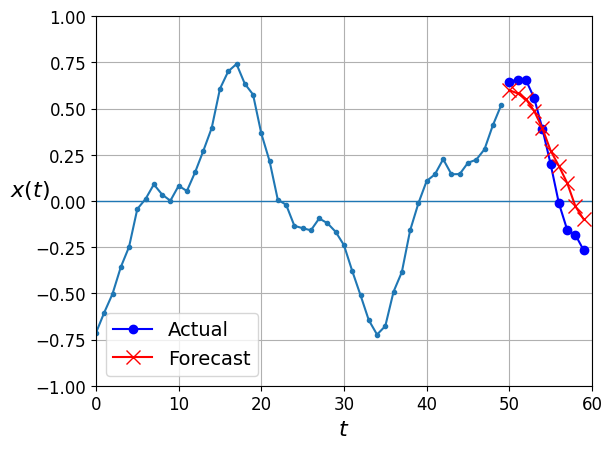

In [36]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

Now let's create an RNN that predicts the next 10 steps at each time step. That is, instead of just forecasting time steps 50 to 59 based on time steps 0 to 49, it will forecast time steps 1 to 10 at time step 0, then time steps 2 to 11 at time step 1, and so on, and finally it will forecast time steps 50 to 59 at the last time step. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

In [37]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [38]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [39]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.legacy.Adam(learning_rate=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 6s 25ms/step - loss: 0.0523 - last_time_step_mse: 0.0421 - val_loss: 0.0425 - val_last_time_step_mse: 0.0308
Epoch 2/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0407 - last_time_step_mse: 0.0288 - val_loss: 0.0333 - val_last_time_step_mse: 0.0194
Epoch 3/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0335 - last_time_step_mse: 0.0214 - val_loss: 0.0312 - val_last_time_step_mse: 0.0203
Epoch 4/20
219/219 [==============================] - 5s 25ms/step - loss: 0.0300 - last_time_step_mse: 0.0179 - val_loss: 0.0262 - val_last_time_step_mse: 0.0130
Epoch 5/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0262 - last_time_step_mse: 0.0135 - val_loss: 0.0235 - val_last_time_step_mse: 0.0105
Epoch 6/20
219/219 [==============================] - 5s 25ms/step - loss: 0.0234 - last_time_step_mse: 0.0109 - val_loss: 0.0234 - val_last_time_step_mse: 0.0111
Epoch 7/20
219/219 [==

In [40]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 [==============================] - 0s 127ms/step


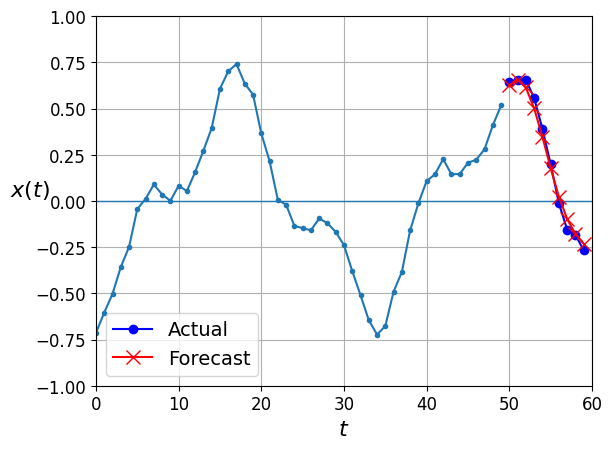

In [41]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# Deep RNN with Batch Norm

In [42]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

optimizer=tf.keras.optimizers.legacy.Adam()
model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 7s 26ms/step - loss: 0.1921 - last_time_step_mse: 0.1716 - val_loss: 0.0865 - val_last_time_step_mse: 0.0776
Epoch 2/20
219/219 [==============================] - 6s 25ms/step - loss: 0.0540 - last_time_step_mse: 0.0439 - val_loss: 0.0519 - val_last_time_step_mse: 0.0421
Epoch 3/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0466 - last_time_step_mse: 0.0365 - val_loss: 0.0451 - val_last_time_step_mse: 0.0345
Epoch 4/20
219/219 [==============================] - 5s 25ms/step - loss: 0.0420 - last_time_step_mse: 0.0312 - val_loss: 0.0404 - val_last_time_step_mse: 0.0295
Epoch 5/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0383 - last_time_step_mse: 0.0267 - val_loss: 0.0373 - val_last_time_step_mse: 0.0256
Epoch 6/20
219/219 [==============================] - 6s 25ms/step - loss: 0.0357 - last_time_step_mse: 0.0235 - val_loss: 0.0356 - val_last_time_step_mse: 0.0232
Epoch 7/20
219/219 [==

# Deep RNNs with Layer Norm

In [43]:
#from tensorflow.keras.layers import LayerNormalization
from keras.layers import LayerNormalization

In [44]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [45]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

optimizer=tf.keras.optimizers.legacy.Adam()
model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
  3/219 [..............................] - ETA: 9s - loss: 0.6127 - last_time_step_mse: 0.5811  

2023-04-04 13:15:05.308735: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600


219/219 [==============================] - 13s 54ms/step - loss: 0.1121 - last_time_step_mse: 0.0978 - val_loss: 0.0626 - val_last_time_step_mse: 0.0526
Epoch 2/20
219/219 [==============================] - 16s 71ms/step - loss: 0.0583 - last_time_step_mse: 0.0486 - val_loss: 0.0546 - val_last_time_step_mse: 0.0455
Epoch 3/20
219/219 [==============================] - 14s 66ms/step - loss: 0.0517 - last_time_step_mse: 0.0415 - val_loss: 0.0484 - val_last_time_step_mse: 0.0380
Epoch 4/20
219/219 [==============================] - 14s 65ms/step - loss: 0.0461 - last_time_step_mse: 0.0355 - val_loss: 0.0437 - val_last_time_step_mse: 0.0340
Epoch 5/20
219/219 [==============================] - 15s 67ms/step - loss: 0.0416 - last_time_step_mse: 0.0309 - val_loss: 0.0401 - val_last_time_step_mse: 0.0301
Epoch 6/20
219/219 [==============================] - 14s 66ms/step - loss: 0.0390 - last_time_step_mse: 0.0280 - val_loss: 0.0375 - val_last_time_step_mse: 0.0262
Epoch 7/20
219/219 [=======

# Creating a Custom RNN Class

In [46]:
class MyRNN(keras.layers.Layer):
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences
        self.get_initial_state = getattr(
            self.cell, "get_initial_state", self.fallback_initial_state)
    def fallback_initial_state(self, inputs):
        batch_size = tf.shape(inputs)[0]
        return [tf.zeros([batch_size, self.cell.state_size], dtype=inputs.dtype)]
    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)
        shape = tf.shape(inputs)
        batch_size = shape[0]
        n_steps = shape[1]
        sequences = tf.TensorArray(
            inputs.dtype, size=(n_steps if self.return_sequences else 0))
        outputs = tf.zeros(shape=[batch_size, self.cell.output_size], dtype=inputs.dtype)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                sequences = sequences.write(step, outputs)
        if self.return_sequences:
            return tf.transpose(sequences.stack(), [1, 0, 2])
        else:
            return outputs

In [47]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    MyRNN(LNSimpleRNNCell(20), return_sequences=True,
          input_shape=[None, 1]),
    MyRNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

optimizer=tf.keras.optimizers.legacy.Adam()
model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20


2023-04-04 13:19:47.603857: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype float and shape [?,?,1]
	 [[{{node Placeholder}}]]
2023-04-04 13:19:47.691018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype float and shape [?,?,20]
	 [[{{node Placeholder}}]]


219/219 [==============================] - 16s 67ms/step - loss: 0.1450 - last_time_step_mse: 0.1322 - val_loss: 0.0623 - val_last_time_step_mse: 0.0509
Epoch 2/20
219/219 [==============================] - 15s 69ms/step - loss: 0.0557 - last_time_step_mse: 0.0451 - val_loss: 0.0507 - val_last_time_step_mse: 0.0401
Epoch 3/20
219/219 [==============================] - 15s 67ms/step - loss: 0.0474 - last_time_step_mse: 0.0367 - val_loss: 0.0446 - val_last_time_step_mse: 0.0334
Epoch 4/20
219/219 [==============================] - 14s 66ms/step - loss: 0.0429 - last_time_step_mse: 0.0320 - val_loss: 0.0405 - val_last_time_step_mse: 0.0285
Epoch 5/20
219/219 [==============================] - 14s 66ms/step - loss: 0.0406 - last_time_step_mse: 0.0286 - val_loss: 0.0383 - val_last_time_step_mse: 0.0248
Epoch 6/20
219/219 [==============================] - 14s 65ms/step - loss: 0.0360 - last_time_step_mse: 0.0216 - val_loss: 0.0343 - val_last_time_step_mse: 0.0197
Epoch 7/20
219/219 [=======

# LSTMs

In [48]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

optimizer=tf.keras.optimizers.legacy.Adam()

model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20


2023-04-04 13:24:29.090311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-04 13:24:29.091362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-04 13:24:29.092012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

215/219 [============================>.] - ETA: 0s - loss: 0.0803 - last_time_step_mse: 0.0660

2023-04-04 13:24:32.964493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-04 13:24:32.965565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-04 13:24:32.966267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

219/219 [==============================] - 4s 12ms/step - loss: 0.0798 - last_time_step_mse: 0.0655 - val_loss: 0.0553 - val_last_time_step_mse: 0.0368
Epoch 2/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0467 - last_time_step_mse: 0.0266 - val_loss: 0.0400 - val_last_time_step_mse: 0.0198
Epoch 3/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0373 - last_time_step_mse: 0.0171 - val_loss: 0.0357 - val_last_time_step_mse: 0.0161
Epoch 4/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0342 - last_time_step_mse: 0.0147 - val_loss: 0.0330 - val_last_time_step_mse: 0.0133
Epoch 5/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0321 - last_time_step_mse: 0.0135 - val_loss: 0.0313 - val_last_time_step_mse: 0.0132
Epoch 6/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0304 - last_time_step_mse: 0.0120 - val_loss: 0.0294 - val_last_time_step_mse: 0.0110
Epoch 7/20
219/219 [===============

In [49]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 5ms/step - loss: 0.0233 - last_time_step_mse: 0.0080


[0.02327839285135269, 0.008030006662011147]

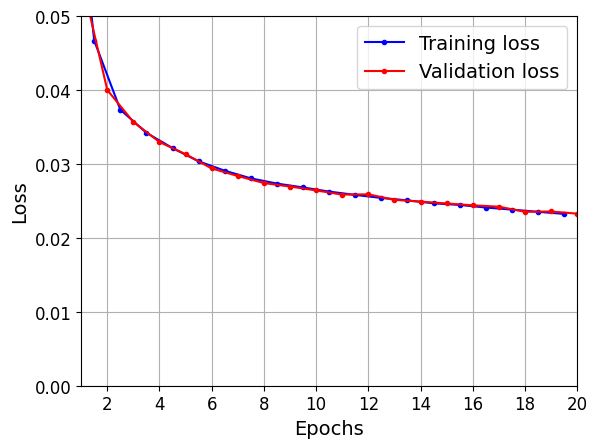

In [50]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [51]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

2023-04-04 13:25:13.175645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-04 13:25:13.176571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-04 13:25:13.177468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 335ms/step


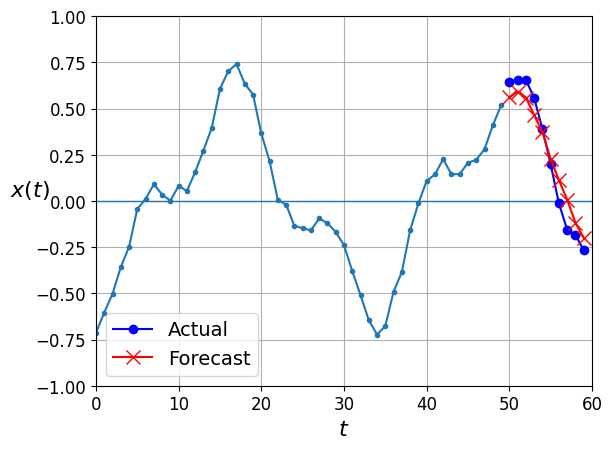

: 

In [52]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()